In [2]:
import torch
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from mem_transformer import MemTransformerLM
from dgl.nn.pytorch import GATConv

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [2]:
num_notes = 128
num_time_shifts = 100
num_velocities = 32
message_dim = 2*num_notes + num_velocities + num_time_shifts
instrument_numbers = [0, 6, 40, 41, 42, 43, 45, 60, 68, 70, 71, 73]
num_instruments = len(instrument_numbers)

# Model definition
Uses Transformer XL

In [17]:
# EnsembleTransformer: takes a history of MIDI messages 
# for instruments in an ensemble and generates distributions for the next message
class EnsembleTransformer(torch.nn.Module):
    # CONSTRUCTOR
    # ARGUMENTS
    # message_dim: dimension of a MIDI message
    # embed_dim: dimension of message embedding
    # num_instruments: number of instrument labels
    # heads: number of attention heads
    # attention_layers: number of attention layers
    # ff_size: size of the feedforward output at the end of the decoder
    # chunk_size: we process sequences in chunks of this size
    def __init__(self, message_dim, embed_dim, num_instruments, heads, attention_layers, ff_size, chunk_size):
        super(EnsembleTransformer, self).__init__()
        
        self.embed_dim = embed_dim
        self.chunk_size = chunk_size
        
        # We add the tanhed instrument embedding to each input message 
        # (this is the global conditioning idea from DeepJ, which comes from WaveNet)
        self.i_embedding = torch.nn.Embedding(num_instruments, embed_dim)
        
        # A TransformerXL is used to transform a chunk of messages from an instrument, as
        # well as a hidden state encoding the history of messages from all instruments,
        # into a new set of hidden states and a distribution for the next message
        # for the instrument
        assert(embed_dim%heads == 0)
        
        # TODO: There are a bunch of parameters whose purpose I don't understand (e.g. tie_proj, cutoff).
        # Should we use them?
        
        # TODO: should d_model and d_inner be different? Why do they set ext_len to 0 during training?
        self.transformer = MemTransformerLM(message_dim, attention_layers, heads, \
                                            embed_dim, embed_dim // heads, embed_dim, 0.1, \
                                            dropatt=0, tie_weight=True, \
                                            d_embed=embed_dim, div_val=1, \
                                            pre_lnorm=True, \
                                            tgt_len=chunk_size, ext_len=0, mem_len=chunk_size, \
                                            attn_type=0)
        
        # Between chunks, we compute attentions across the current hidden states from all the instruments,
        # producing new hidden states for each
        # https://docs.dgl.ai/en/0.4.x/_modules/dgl/nn/pytorch/conv/gatconv.html
        self.inst_attention = GATConv(embed_dim, embed_dim, heads)
    
    # forward: generates the next MIDI message
    # for each instrument in an ensemble, given the ensemble history
    # ARGUMENTS
    # history: an LxNxB tensor, where L is the length of the longest history in
    # the batch, N is the max number of instruments in the batch, and B is the batch size. As we
    # walk along the first dimension, we should see indices of MIDI events for a particular
    # instrument
    # instruments: an NxB tensor indicating the instrument for each sequence in each batch
    # seq_lengths: an NxB tensor containing the sequence length for each instrument in each batch
    # mask: an LxNxB tensor containing True where messages actually exist and False in padding
    # locations
    # RETURN: loss, as well as an NxB tensor containing the predicted next message for each sequence
    def forward(self, history, instruments, seq_lengths, mask):
        L = history.shape[0] # longest length
        N = history.shape[1] # max instruments
        B = history.shape[2] # batch size
        assert(instruments.shape == (N, B))
        assert(seq_lengths.shape == instruments.shape)
        assert(mask.shape == history.shape)
        
        mems = [[None for b in range(B)] for i in range(N)]
        next_messages = torch.zeros((N, B), dtype=torch.long)
        
        # Target sequence is just the original sequence shifted left
        tgt = torch.zeros((L, N, B), dtype=torch.long)
        tgt[:-1] = history[1:]
        
        tgt_mask = torch.zeros((L, N, B), dtype=torch.bool)
        tgt_mask[:-1] = mask[1:]
        
        loss = torch.tensor(0)
        
        for chunk_start in range(0, L, self.chunk_size):
            chunk_end = min(i + self.chunk_size, L)
            
            for inst in range(N):
                # Only propagate sequences that aren't finished
                sel_idx = [b for b in range(B) if seq_lengths[inst, b] > chunk_start]
                output = self.transformer(history[chunk_start:chunk_end, inst, sel_idx], \
                                          tgt[chunk_start:chunk_end, inst, sel_idx], \
                                          mems[inst]
                                          inst)
                
                loss_mask = tgt_mask[chunk_start:chunk_end, inst, sel_idx]
                loss = loss + output[0][loss_mask]
                
                mems[inst][sel_idx] = output[1:]
                
                # If we've reached the last chunk for an instrument, populate its
                # predicted next message
                done_idx = [b for b in range(B) if (seq_lengths[inst, b] > chunk_start and seq_lengths[inst, b] <= chunk_end)]
                for d in done_idx:
                    next_messages[inst, d] = #TODO: get logits from transformer
                    
            # Update memory for each sequence using self.inst_attention
                
        # Average loss over all targets
        loss /= torch.sum(tgt_mask)

        return loss, next_messages

# Tests
We train with model.eval() to disable dropout, since these tests try to get the model to overfit to a small sequence

Get the model to overfit to a single instrument's part in a single song (only the first 100 time steps). Tests decoder

In [ ]:
ff_size = 512
heads = 8
attention_layers=  6
embed_dim = 256
chunk_size = 100

grad_clip = 10

model = EnsembleTransformer(message_dim, embed_dim, num_instruments, heads, attention_layers, ff_size, chunk_size)
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))
    
model.eval() # Training with eval just to see if we can overfit without dropout

In [ ]:
model.load_state_dict(torch.load('overfit_single_instrument.pth'))

In [ ]:
recording = np.load('preprocessed_data/recording318.npy', allow_pickle=True)
instruments_np = np.load('preprocessed_data/instruments318.npy', allow_pickle=True)

inst = 1

max_seq_length = 800

history = torch.tensor(recording[inst][:max_seq_length], dtype=torch.long).view(-1, 1, 1)
mask = torch.zeros(history.shape, dtype=torch.bool)
instruments = torch.tensor(instrument_numbers.index(instruments_np[inst]), dtype=torch.long).view(1, 1, 1)

max_instruments = history.shape[1]

batch_size = 1
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 150
train_losses = np.zeros(epochs)

target_messages = history[1:].flatten()

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    # Index of the instrument we want to generate music for (there's only one instrument)
    gen_idx = 0
    
    # Move forward in time
    logits = model(history[:-1], mask[:-1], instruments, gen_idx).view(-1, message_dim)
                
    loss = loss_fn(logits, target_messages)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses[epoch] = loss.data
    print('Loss: %f' %(loss.data))

In [48]:
torch.save(model.state_dict(), 'overfit_single_instrument2.pth')

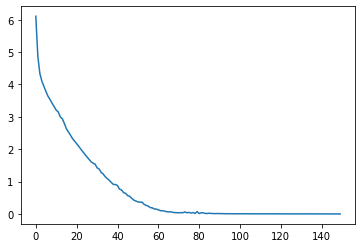

In [11]:
plt.plot(train_losses)

In [12]:
# Sample from model
gen_history = torch.tensor(recording[inst][0], dtype=torch.long).view(-1, 1, 1)
mask = torch.zeros((1, 1, 1), dtype=torch.bool)
instruments = torch.tensor(instrument_numbers.index(instruments_np[inst]), dtype=torch.long).view(1, 1, 1)
model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

seq_length = 100
max_instruments = history.shape[1]

# Index of the instrument we want to generate music for (there's only one instrument)
gen_idx = 0

# Move forward in time
wrong_cnt = 0
for t in range(1, seq_length):
    logits = model(gen_history, mask, instruments, gen_idx)
    probs = torch.nn.functional.softmax(logits[t - 1], dim=1)
    gen_history = torch.cat((gen_history, torch.multinomial(probs, 1).view(1, 1, -1)))
    #gen_history = torch.cat((gen_history, torch.argmax(probs.flatten()).view(1, 1, 1)))
    if torch.argmax(probs.flatten()) != history[t].flatten():
        wrong_cnt += 1
        print(torch.topk(probs.flatten(), 10))
        print(history[t])
    
    mask = torch.cat((mask, torch.zeros((1, 1, 1), dtype=torch.bool)))

print(wrong_cnt)

0


In [63]:
np.save('test_history.npy', np.array([history.flatten().numpy()], dtype='object'))
np.save('test_instruments.npy', np.array([instrument_numbers[instruments[0]]]))

Get the model to overfit to two instruments' parts in a single song

In [ ]:
ff_size = 512
heads = 8
attention_layers=  6
embed_dim = 256

grad_clip = 10

model = EnsembleTransformer(message_dim, embed_dim, num_instruments, heads, attention_layers, ff_size)
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))
    
model.eval() # Training with eval just to see if we can overfit without dropout

In [5]:
model.load_state_dict(torch.load('overfit_two_instruments.pth'))

<All keys matched successfully>

In [ ]:
recording = np.load('preprocessed_data/recording318.npy', allow_pickle=True)
instruments_np = np.load('preprocessed_data/instruments318.npy', allow_pickle=True)

max_seq_length = 1000
max_instruments = instruments_np.shape[0]
batch_size = 1

history = torch.zeros((max_seq_length, max_instruments, batch_size), dtype=torch.long)
mask = torch.ones(history.shape, dtype=torch.bool)
instruments = torch.tensor([instrument_numbers.index(instruments_np[i]) for i in range(max_instruments)], dtype=torch.long).view(1, -1, 1)

for inst in range(max_instruments):
    history[:max_seq_length, inst, 0] = torch.tensor(recording[inst][:max_seq_length], dtype=torch.long)
    mask[:max_seq_length, inst, 0] = False

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 300
train_losses = np.zeros(epochs)
num_targets = max_seq_length - 1

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    
    loss = torch.tensor([0], dtype=torch.float32)
    for inst in range(max_instruments):
        logits = model(history[:-1], mask[:-1], instruments, inst)

        logits = logits.view(-1, message_dim)
        target_messages = history[1:, inst].flatten()
        output_mask = torch.logical_not(mask[1:, inst].flatten())
        loss = loss + loss_fn(logits[output_mask], target_messages[output_mask])
                
    loss = loss/max_instruments
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    train_losses[epoch] = loss.data
    print('Loss = %f' %(loss.data))

In [15]:
torch.save(model.state_dict(), 'overfit_two_instruments.pth')

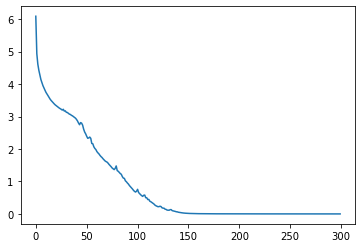

In [16]:
plt.plot(train_losses)

In [ ]:
# Check if each instrument can reconstruct its part, given the other instrument's part
model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

for inst in range(max_instruments):
    gen_history = history.clone()

    # Move forward in time
    wrong_cnt = 0
    for t in range(1, max_seq_length):
        input_mask = mask.clone()
        input_mask[t:] = True
        logits = model(gen_history, input_mask, instruments, inst)
        probs = torch.nn.functional.softmax(logits[t - 1], dim=1)
        gen_history[t, inst, 0] = torch.multinomial(probs, 1)
        if torch.argmax(probs.flatten()) != history[t, inst].flatten():
            wrong_cnt += 1
            print(torch.topk(probs.flatten(), 10))
            print(history[t, inst])

    print(wrong_cnt)

0


In [ ]:
recording = np.load('preprocessed_data/recording318.npy', allow_pickle=True)
instruments_np = np.load('preprocessed_data/instruments318.npy', allow_pickle=True)

max_seq_length = 1000
max_instruments = instruments_np.shape[0]
batch_size = 1

history = torch.zeros((max_seq_length, max_instruments, batch_size), dtype=torch.long)
mask = torch.ones(history.shape, dtype=torch.bool)
instruments = torch.tensor([instrument_numbers.index(instruments_np[i]) for i in range(max_instruments)], dtype=torch.long).view(1, -1, 1)

for inst in range(max_instruments):
    history[:max_seq_length, inst, 0] = torch.tensor(recording[inst][:max_seq_length], dtype=torch.long)
    mask[:max_seq_length, inst, 0] = False

# Check if the instruments can jointly reconstruct the piece
gen_history = history.clone()

model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

wrong_cnt = 0

for t in range(1, max_seq_length):
    input_mask = mask.clone()
    input_mask[t:] = True
    for inst in range(max_instruments):
        logits = model(gen_history, input_mask, instruments, inst)
        probs = torch.nn.functional.softmax(logits[t - 1], dim=1)
        gen_history[t, inst, 0] = torch.multinomial(probs, 1)
        if torch.argmax(probs.flatten()) != history[t, inst].flatten():
            wrong_cnt += 1
           
    if t%50 == 0:
        print(t)

print(wrong_cnt)

# Custom dataset class

In [4]:
# Custom Dataset class
class MIDIDataset(torch.utils.data.Dataset):
    # CONSTRUCTOR: creates a list of recording files and a list
    # of instrument files in root_dir. Assumes that the directory
    # contains recording0.npy to recordingM.npy,
    # as well as instruments0.npy to instrumentsM.npy
    # ARGUMENTS
    # root_dir: the directory to search
    def __init__(self, root_dir, transform=None):
        files = os.listdir(root_dir)
        self.recordings = []
        self.instrument_files = []
        for file in files:
            if 'recording' in file:
                self.recordings.append(os.path.join(root_dir, file))
            elif 'instruments' in file:
                self.instrument_files.append(os.path.join(root_dir, file))
                
        assert(len(self.recordings) == len(self.instrument_files))
        self.recordings.sort()
        self.instrument_files.sort()
        self.transform = transform

    # __len__
    # RETURN: the number of recording files in the dataset
    def __len__(self):
        return len(self.recordings)

    # __getitem__
    # ARGUMENTS
    # idx: indicates which file to get
    # RETURN: an instance with keys 'instruments', 'history'
    # instance['history'] is a numpy array of message sequences for each instrument
    # instance['instruments'] a numpy array of instrument numbers
    def __getitem__(self, idx):
        instance = {'history': np.load(self.recordings[idx], allow_pickle=True), \
                    'instruments': np.load(self.instrument_files[idx], allow_pickle=True)}
        
        assert(len(instance['history']) == len(instance['instruments']))
        
        if self.transform:
            instance = self.transform(instance)
            
        return instance

In [5]:
# collate_fn: takes a list of samples from the dataset and turns them into a batch.
# ARGUMENTS
# batch: a list of dictionaries
# RETURN: a sample with keys 'history', 'instruments', and 'mask'
# sample['history']: an LxNxB tensor containing messages
# sample['instruments']: a 1xNxB tensor containing instrument numbers
# sample['mask']: an LxNxB tensor containing False where a message is
# valid, and True where it isn't (accounts for variable length sequences
# and zero padding)
def collate_fn(batch):
    batch_size = len(batch)
    
    # We size our tensors to accomodate the longest sequence and the largest ensemble
    max_instruments = max([len(instance['history']) for instance in batch])
    max_len = max([max([seq.shape[0] for seq in instance['history']]) for instance in batch])

    sample = {'history': torch.ones((max_len, max_instruments, batch_size), dtype=torch.long), \
              'instruments': torch.zeros((1, max_instruments, batch_size), dtype=torch.long), \
              'mask': torch.ones((max_len, max_instruments, batch_size), dtype=torch.bool)}

    for b in range(batch_size):
        instrument_idx = [instrument_numbers.index(inst) for inst in batch[b]['instruments']]
        sample['instruments'][0, :len(instrument_idx), b] = torch.tensor(instrument_idx, dtype=torch.long)
        
        for inst_idx in range(len(batch[b]['history'])):
            seq_len = len(batch[b]['history'][inst_idx])
            sample['history'][:seq_len, inst_idx, b] = torch.tensor(batch[b]['history'][inst_idx], dtype=torch.long)
            sample['mask'][:seq_len, inst_idx, b] = False
            
    return sample

# Train the model

In [24]:
ff_size = 512
heads = 8
attention_layers=  6
embed_dim = 256
grad_clip = 10

model = EnsembleTransformer(message_dim, embed_dim, len(instrument_numbers), heads, attention_layers, ff_size)

for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

In [ ]:
batch_size = 1
learning_rate = 0.001

dataset = MIDIDataset('preprocessed_data')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs) # TODO: train/test split. Can we do this with Dataloader?

model.train()

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    for b, batch in enumerate(dataloader):
        print('Starting iteration %d' %(b))
        max_seq_length = batch['history'].shape[0]
        num_targets = max_seq_length - 1 # Messages start from t = 0, but we start generating at t = 1
        max_instruments = batch['history'].shape[1]
        loss = torch.tensor([0])
        for inst in range(max_instruments):         
            mask = batch['mask']
            
            logits = model(batch['history'][:-1], mask[:-1], batch['instruments'], inst)
            logits = logits.view(-1, message_dim)
            target_messages = batch['history'][1:, inst].flatten()
            output_mask = torch.logical_not(mask[1:, inst].flatten())
            loss = loss + loss_fn(logits[output_mask], target_messages[output_mask])
        
        loss /= max_instruments
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.save(model.state_dict(), 'trained_models/epoch' + str(epoch) + '.pth')

# Sample from the model

In [5]:
model.load_state_dict(torch.load('trained_models/epoch4.pth'))

<All keys matched successfully>

In [ ]:
model.eval() # Disable dropout to make results repeatable

time_steps = 5000 # How many time steps do we sample?

max_instruments = 3

# Piano, violin, viola
instruments = torch.tensor([0, 2, 3]).view(1, max_instruments, 1)

# Suppose they all start with the same velocity message
# TODO: should we have SOS and EOS tokens like in NLP?
gen_history = 24*torch.ones((1, max_instruments, 1), dtype=torch.long)
mask = torch.zeros((1, 1, 1), dtype=torch.bool)

for t in range(1, time_steps):
    # Sanity check
    if t%100 == 0:
        print(t)
    next_messages = torch.zeros((1, max_instruments, 1), dtype=torch.long)
    for inst in range(max_instruments):
        logits = model(gen_history, mask.expand(t, max_instruments, -1), instruments, inst)
        probs = torch.nn.functional.softmax(logits[t - 1], dim=1)
        next_messages[0, inst, 0] = torch.multinomial(probs, 1)
    
    gen_history = torch.cat((gen_history, next_messages))

Save samples

In [15]:
gen_recording = np.array([0 for i in range(max_instruments)], dtype='object')
for i in range(max_instruments):
    gen_recording[i] = gen_history[:, i].flatten().numpy()
    
gen_instruments = np.array([instrument_numbers[instruments[0, i, 0].item()] for i in range(max_instruments)])
np.save('gen_recording.npy', gen_recording)
np.save('gen_instruments.npy', gen_instruments)